In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math

In [42]:
img = cv2.imread('partitura.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)

In [43]:

h, w = img.shape
center = (w//2, h//2)
theta_1 = -50.0
theta_2 = 50.0
valor_maximo = -1.0
melhor_theta = -11.0
for theta in np.arange(theta_1, theta_2, 1):
    matriz_rotacao = cv2.getRotationMatrix2D(center, theta, 1)
    rotate_img = cv2.warpAffine(img, matriz_rotacao, (w, h), borderMode=cv2.BORDER_REPLICATE)
    perfil = []
    for i in range(h):
        perfil.append(np.sum(rotate_img[i]))
    soma = 0
    for i in range(h-1):
        soma += np.power(perfil[i+1] - perfil[i], 2)
    if (soma > valor_maximo):
        valor_maximo = soma
        melhor_theta = theta
print(melhor_theta)


26.0


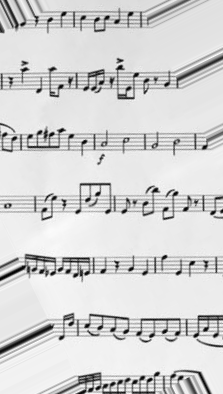

In [44]:

matriz = cv2.getRotationMatrix2D(center, melhor_theta, 1)
rotate_img = cv2.warpAffine(img, matriz, (w, h), borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotate_img)

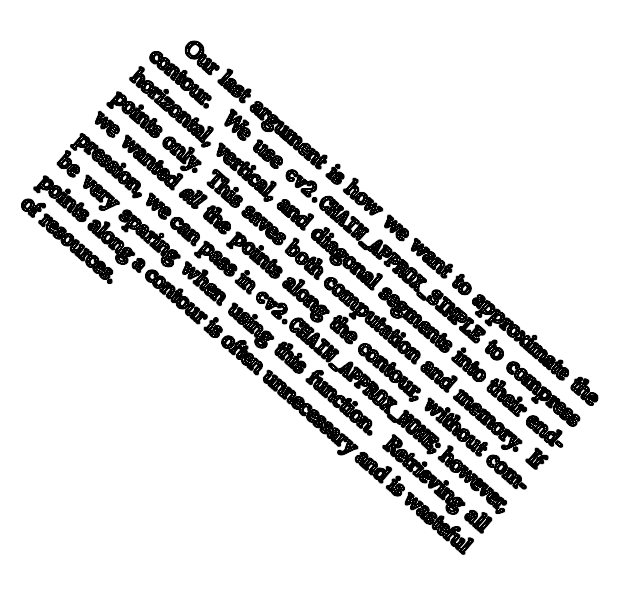

In [14]:
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
mag = cv2.convertScaleAbs(mag)
mag = cv2.bitwise_not(mag)
# cv2.imwrite('teste.png', mag)
cv2_imshow(mag)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [53]:
img = cv2.imread('pos_41.png', cv2.IMREAD_GRAYSCALE)

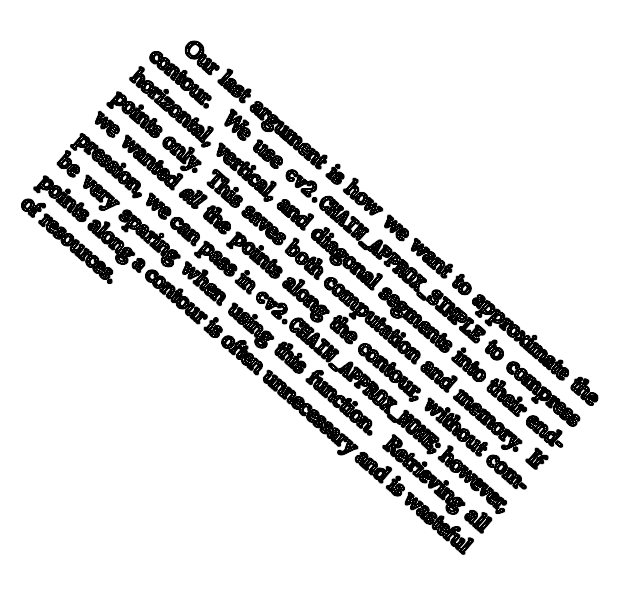

In [54]:
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
mag = cv2.convertScaleAbs(mag)
new_img = cv2.bitwise_not(mag).astype(float)
cv2_imshow(new_img)

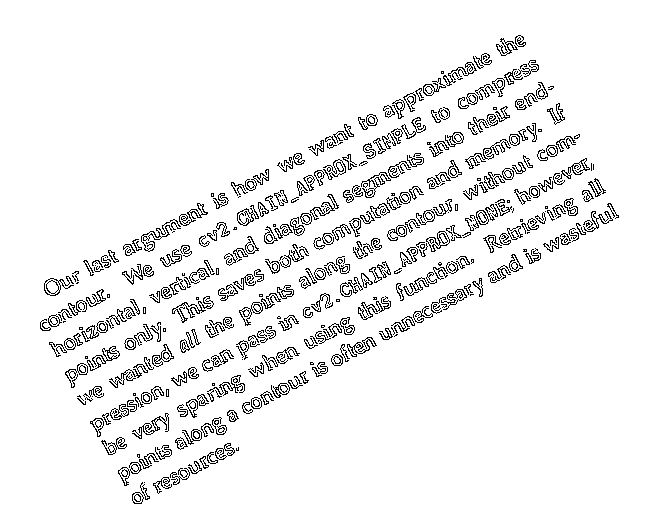

102
215.0
90


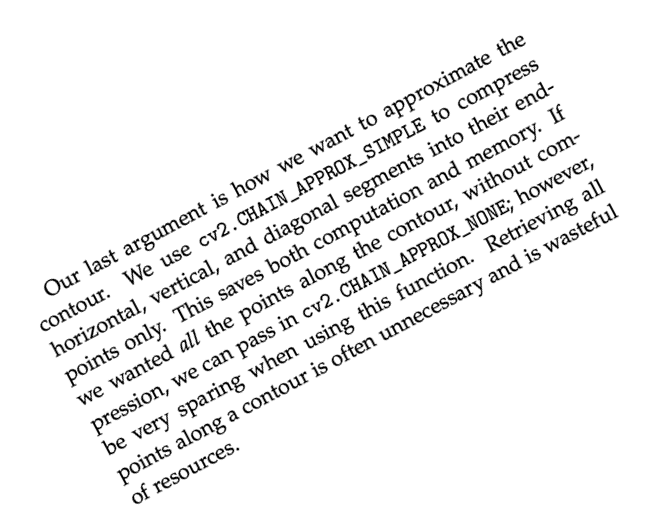

In [66]:
img = cv2.imread('neg_28.png', cv2.IMREAD_GRAYSCALE)
# Usado canny ao inves de sobel porque sobel tinha bordas muito grossas o que ocasionava em um maior
# tempo de execução já que haveria muito mais pontos em preto
new_img = cv2.Canny(img, 100, 200)
new_img = cv2.bitwise_not(new_img).astype(float)
cv2_imshow(new_img)


h, w = new_img.shape
acumulador = {theta : {} for theta in range(0, 181)}
maior_valor = -1
melhor_theta = 0
melhor_ro = 0
seno = {theta:math.sin(math.radians(theta)) for theta in range(0, 181)}
cosseno = {theta:math.cos(math.radians(theta)) for theta in range(0, 181)}
delta = 1

def calcular_bins():
    d = np.sqrt(w**2+h**2)
    n = math.ceil(2 * d / delta)
    return n

def calcular_valor_min()

def transformada_hough(x, y, theta):
    return round(x * cosseno[theta] + y * seno[theta],2)

for i in range(h):
    for j in range(w):
        if (new_img[i][j] != 0):
            continue
        for theta in range(0, 181):
            ro = transformada_hough(j , i, theta)
            if (acumulador[theta].get(ro, None) is None):
                acumulador[theta][ro] = 0
            acumulador[theta][ro]+=1
for theta in acumulador.keys():
    for ro, valor in acumulador[theta].items():
        if (valor > maior_valor):
            melhor_theta = theta
            maior_valor = valor
            melhor_ro = ro
print(maior_valor)
print(melhor_ro)
print(melhor_theta)

center = (w//2, h//2)
matriz = cv2.getRotationMatrix2D(center, melhor_theta-90, 1)
rotate_img = cv2.warpAffine(img, matriz, (w, h), borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotate_img)

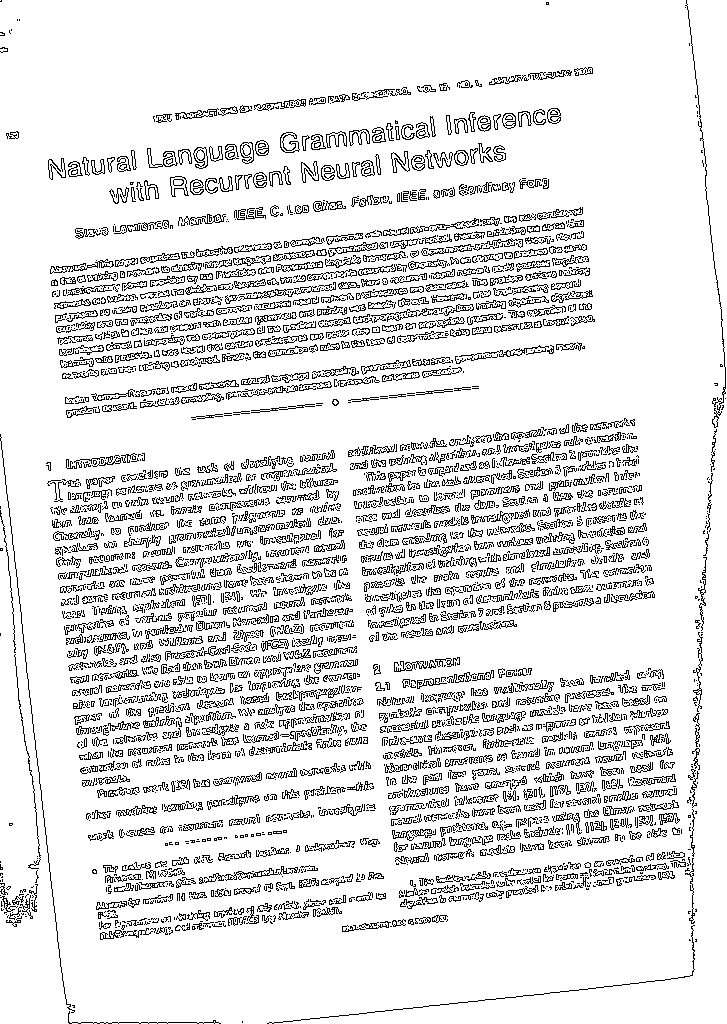

-6


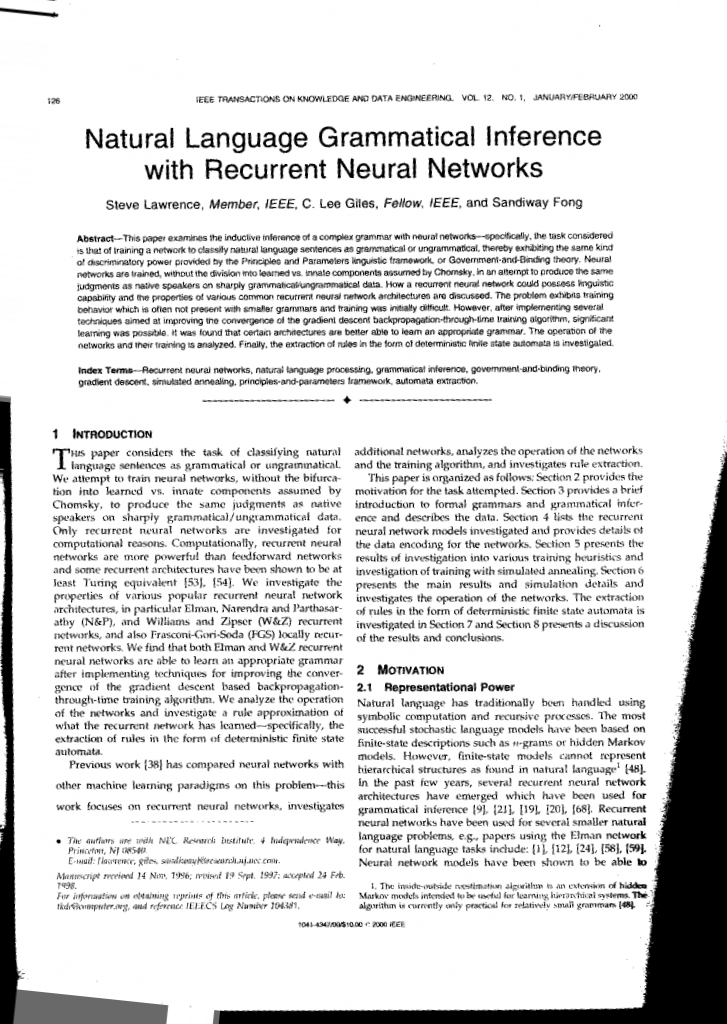

In [89]:

def fundo_branco(h, w):
    size = math.ceil(max(h, w) * math.sqrt(2)) # usando pensando no valor maximo que a diagonal maior pode ter
    new_image = np.ones((size, size,), dtype=np.uint8) * 255
    x_offset = (size - w) //2
    y_offset = (size - h) //2
    new_image[y_offset:y_offset+h, x_offset:x_offset + w] = img
    return new_image

def calcular_bins():
    d = np.sqrt(w**2+h**2)
    n = math.ceil(2 * d / delta)
    return n
img = cv2.imread('sample2.png', cv2.IMREAD_GRAYSCALE)
# Usado canny ao inves de sobel porque sobel tinha bordas muito grossas o que ocasionava em um maior
# tempo de execução já que haveria muito mais pontos em preto
new_img = cv2.Canny(img, 100, 200)
new_img = cv2.bitwise_not(new_img).astype(float)
# new_img = fundo_branco(new_img.shape[0], new_img.shape[1])

cv2_imshow(new_img)

h, w = new_img.shape
maior_valor = -1
melhor_theta = 0
delta = 3
n_bins = calcular_bins()
acumulador = [[0 for _ in range(n_bins)] for theta in range(181)]
seno = {theta:math.sin(math.radians(theta)) for theta in range(0, 181)}
cosseno = {theta:math.cos(math.radians(theta)) for theta in range(0, 181)}



def transformada_hough(x, y, theta):
    return round(x * cosseno[theta] + y * seno[theta],2)

for i in range(h):
    for j in range(w):
        if (new_img[i][j] != 0):
            continue
        for theta in range(0, 181):
            rho = int(transformada_hough(j , i, theta))
            idx_rho = rho//delta
            acumulador[theta][idx_rho] += 1
for idx_theta, theta in enumerate(acumulador):
    for valor in theta:
        if (valor > maior_valor):
            melhor_theta = idx_theta
            maior_valor = valor
print(melhor_theta-90)

center = (w//2, h//2)
matriz = cv2.getRotationMatrix2D(center, melhor_theta-90, 1)
rotate_img = cv2.warpAffine(img, matriz, (w, h), borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotate_img)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
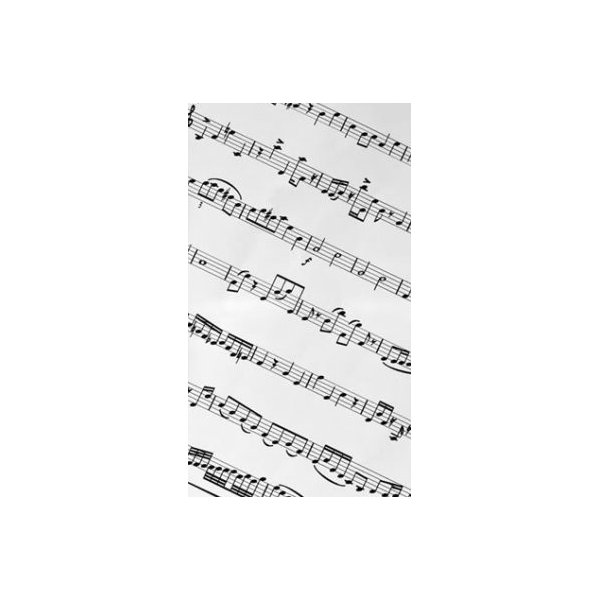

In [82]:
img = cv2.imread('partitura.png', cv2.IMREAD_GRAYSCALE)
def fundo_branco(h, w)
    size = max(h, w) * np.sqrt(2) # usando pensando no valor maximo que a diagonal maior pode ter
    new_image = np.ones((size, size,), dtype=np.uint8) * 255
    x_offset = (size - w) //2
    y_offset = (size - h) //2
    new_image[y_offset:y_offset+h, x_offset:x_offset + w] = img
    return new_image

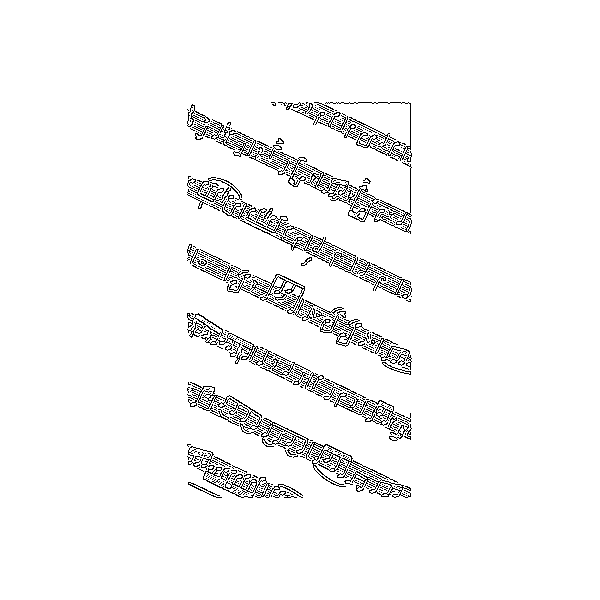

29


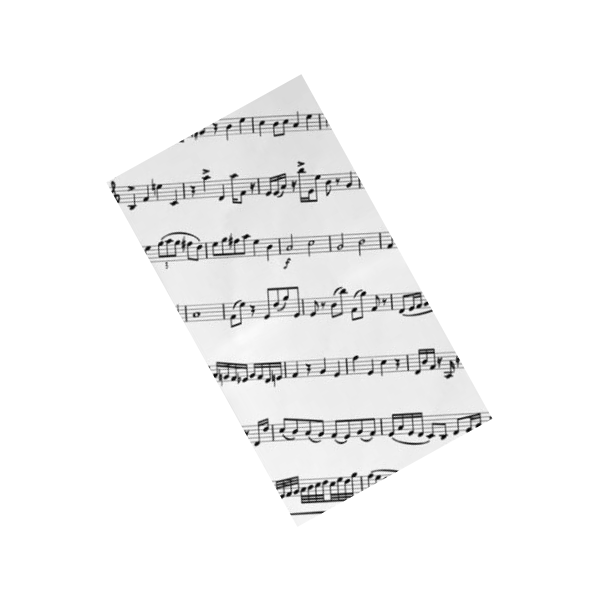

In [83]:
img = canva
new_img = cv2.Canny(img, 100, 200)
new_img = cv2.bitwise_not(new_img).astype(float)
cv2_imshow(new_img)

def calcular_bins():
    d = np.sqrt(w**2+h**2)
    n = math.ceil(2 * d / delta)
    return n

h, w = new_img.shape
maior_valor = -1
melhor_theta = 0
delta = 3
n_bins = calcular_bins()
acumulador = [[0 for _ in range(n_bins)] for theta in range(181)]
seno = {theta:math.sin(math.radians(theta)) for theta in range(0, 181)}
cosseno = {theta:math.cos(math.radians(theta)) for theta in range(0, 181)}



def transformada_hough(x, y, theta):
    return round(x * cosseno[theta] + y * seno[theta],2)

for i in range(h):
    for j in range(w):
        if (new_img[i][j] != 0):
            continue
        for theta in range(0, 181):
            rho = int(transformada_hough(j , i, theta))
            idx_rho = rho//delta
            acumulador[theta][idx_rho] += 1
for idx_theta, theta in enumerate(acumulador):
    for valor in theta:
        if (valor > maior_valor):
            melhor_theta = idx_theta
            maior_valor = valor
print(melhor_theta-90)

center = (w//2, h//2)
matriz = cv2.getRotationMatrix2D(center, melhor_theta-90, 1)
rotate_img = cv2.warpAffine(img, matriz, (w, h), borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotate_img)